In [1]:
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt


def load_data(path,hemisphere):
    X = pd.read_csv(path + hemisphere + '_nmf_input_raw.csv')
    X = X.to_numpy()
    return(X)

def run_nmf(X,k):
    
    '''1. Rescale columns of X to the interval [0,1].
    2. Run Non-Negative matrix factorization on X with k components.'''

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    model = NMF(n_components = k, init = 'random', max_iter = 10000)
    model.fit_transform(X)
    
    W = model.transform(X)
    clusters = np.argmax(W,1)

    return(clusters, model)


In [2]:

def get_nmf_similarity(X, k, n_shuffle = 5):
    
    '''Calculate the stability of NMF components. 
    1. Randomly split the matrix X in half n_shuffle times.
    2. Run NMF on each half (with k components).
    3. Calculate the adjusted Rand index between the clusters output from each half.'''

    sim = np.zeros(n_shuffle)

    for split in range(n_shuffle):

        # Generate randomly shuffled indices (seed set for reproducibility).
        np.random.seed(split)
        idx = np.split(np.random.permutation(X.shape[1]),2)

        # Get NMF clusters for each split.
        clust_1 = run_nmf(X[:,idx[0]],k)[0]
        clust_2 = run_nmf(X[:,idx[1]],k)[0]

        # Calculate the adjusted Rand index.
        sim[split] = adjusted_rand_score(clust_1,clust_2)
        
    print('Similarity for k = '+ str(k) + ' is ' + str(np.mean(sim)))
    
    return(sim)


In [3]:
def get_nmf_error(X, k_vals = np.arange(1,10)):
    
    '''Calculate the reconstruction error of NMF components.''' 

    error = np.zeros(len(k_vals) + 1)

    for k in k_vals:

        # Get NMF clusters for each split.
        model = run_nmf(X,k)[1]
        error[k] = model.reconstruction_err_
        
        print('Reconstruction error for k = '+ str(k) + ' is ' + str(np.mean(error[k])))
    
    return(error)


In [4]:
# Number of data-set splits.
n_shuffle = 5

# Number of k-values to explore.
n_k = 15

X = load_data('C:\\Users\\jonah\\Documents\\MAGeT\\', 'right')

# Track similarity of NMF components across range of k-values.
k_similarity = np.zeros([n_k,n_shuffle])
for k in range(1,n_k):
    k_similarity[k,:] = get_nmf_similarity(X, k, n_shuffle = n_shuffle)
    


Similarity for k = 1 is 1.0
Similarity for k = 2 is 0.7702696010785463
Similarity for k = 3 is 0.8236438865852627
Similarity for k = 4 is 0.7043723755753316
Similarity for k = 5 is 0.6308250528341178
Similarity for k = 6 is 0.3874659322514677


In [235]:
# Number of k-values to explore.
k_vals = np.arange(1,15)
X = load_data('C:\\Users\\Jonah Kember\\Documents\\MAGeT\\', 'right')

error = get_nmf_error(X, k_vals = k_vals)


Reconstruction error for k = 1 is 149.70925147068155
Reconstruction error for k = 2 is 134.75680756677986
Reconstruction error for k = 3 is 123.3520023013697
Reconstruction error for k = 4 is 116.09768190527035
Reconstruction error for k = 5 is 110.84377693347109
Reconstruction error for k = 6 is 106.64197585758926
Reconstruction error for k = 7 is 103.01680702673389
Reconstruction error for k = 8 is 99.89155446867889
Reconstruction error for k = 9 is 96.96991409074718
Reconstruction error for k = 10 is 94.4276937305826
Reconstruction error for k = 11 is 92.24204841560547
Reconstruction error for k = 12 is 90.28818923561393
Reconstruction error for k = 13 is 88.48873913544334
Reconstruction error for k = 14 is 86.82005417233601


Text(0, 0.5, 'Adjusted Rand Index')

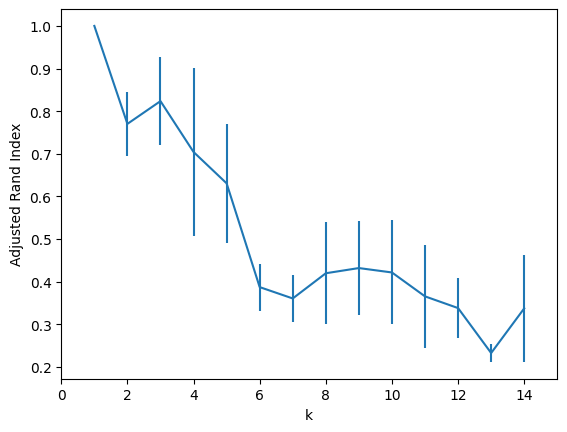

In [145]:
# Plot the similarity of NMF components across splits as a funtion of k.

x = np.arange(k_similarity.shape[0])
y = np.mean(k_similarity,1)
yerr = np.std(k_similarity, axis = 1)

fig, ax = plt.subplots(1)
ax.errorbar(x[1:],y[1:], yerr = yerr[1:])


ax.set_xlim([0,15])
ax.set_xlabel('k')
ax.set_ylabel('Adjusted Rand Index')



Text(0, 0.5, 'Reconstruction error')

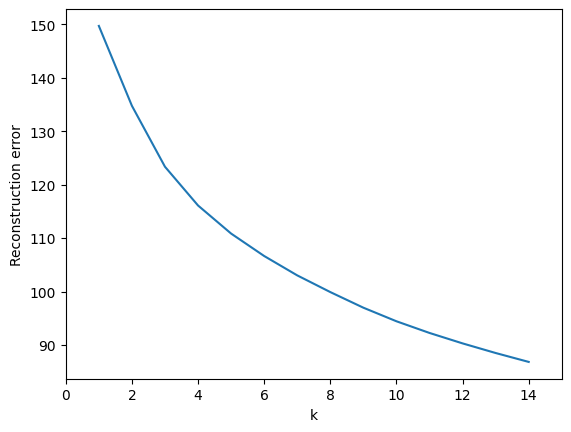

In [236]:
# Plot the reconstruction error of NMF components as a funtion of k.

x = np.arange(error.shape[0])

fig, ax = plt.subplots(1)
ax.plot(x[1:],error[1:])


ax.set_xlim([0,15])
ax.set_xlabel('k')
ax.set_ylabel('Reconstruction error')



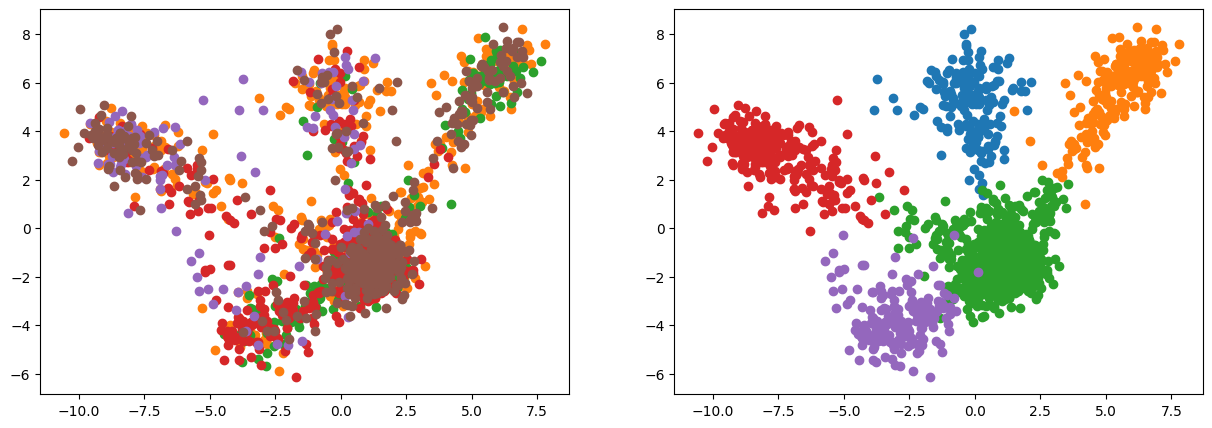

In [180]:
# Load subfield labels.
y = pd.read_csv('right_subfield_labels.csv')
y = y.to_numpy()
y = y.reshape(y.shape[0],)


clusters = run_nmf(X,5)[0]

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import rand_score

model = LinearDiscriminantAnalysis(n_components = 2)
model.fit_transform(X,clusters)
lda_components = model.transform(X)


# Plot Subfields against NMF components in LDA space. 

fig, ax = plt.subplots(1,2,figsize = [15,5])

for subfield in range(6):
    ax[0].plot(lda_components[y == subfield,0], lda_components[y == subfield,1], marker='o', linestyle='')    


for nmf_comp in range(6):
    ax[1].plot(lda_components[clusters == nmf_comp,0], lda_components[clusters == nmf_comp,1], marker='o', linestyle='')    

plt.show()


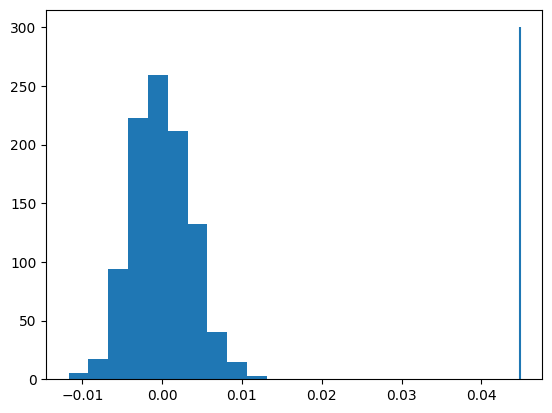

In [181]:
# Test where the empirical Rand index falls in a distribution of null-Rand indices (created through 1000 row-permutations).

empirical = adjusted_rand_score(y,clusters)

n_perm = 1000
null_vars = np.zeros(n_perm)

for perm in range(n_perm):
    np.random.seed(perm)
    null_vars[perm] = adjusted_rand_score(y,np.random.permutation(clusters))

plt.hist(null_vars)
plt.vlines(empirical,ymin = 0, ymax = 300)


In [184]:
# Convert clusters to csv for transformation to nifti.
pd.DataFrame(clusters).to_csv('C:\\Users\\Jonah Kember\\Documents\\MAGeT\\nmf_clusters.csv')


In [262]:

Z = X.copy()
Z.shape

Z.reshape(701520,3)
Z

array([[0.72191167, 0.79436788, 0.75909817, ..., 0.76418841, 0.65398388,
        0.730506  ],
       [0.72510828, 0.78546084, 0.72786679, ..., 0.88426632, 0.65963888,
        0.76356181],
       [0.73222308, 0.78458321, 0.70771907, ..., 1.02003666, 0.64172678,
        0.78128285],
       ...,
       [0.68405477, 0.74138437, 0.72555454, ..., 0.65529586, 0.56045389,
        0.6212992 ],
       [0.70787432, 0.71979637, 0.70232637, ..., 0.61354036, 0.55243068,
        0.53544196],
       [0.74960837, 0.75619531, 0.71799002, ..., 0.57412933, 0.57871644,
        0.46208222]])